In [1]:
import numpy as np
import pandas as pd
import re
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

### Cleaning letter transcript text

Before any NLP analysis, I performed a series of text pre-processing steps to remove punctuation and unnecessary annotations. I also used a couple of functions to get useful metrics like average sentence length and word count for each letter. I saved a separate dataframe "texts" that retains punctuation to be used in the sentiment analysis.

In [2]:
def remove_num(text):
    return re.sub('[0-9]','',text)
def remove_annotations(text):
    text = re.sub('\[.*?]','',text)
    return text.strip()
def remove_punc(text):
    return re.sub('[/.,\'"_’;:]',' ',text)
def remove_header(row):
    first_line = re.match('.*',row.clean_text)[0]
    if row.place in first_line:
        return re.sub(first_line,'',row.clean_text).strip()
    else: return row.clean_text
def count_words(text):
    return len([w for w in text.split() if len(w) > 1])
def count_sent(text):
    return len([s for s in sent_tokenize(text) if len(s) > 1])
def sent_length(text):
    sent_list = sent_tokenize(text)
    words_list = [s.split() for s in sent_list]
    return np.mean([len(t) for t in words_list])
def convert_date(date):
    try: date = pd.to_datetime(date)
    except: date = np.nan
    return date
def get_year(date):
    return int(re.search('[0-9]{4}',date)[0])

In [3]:
df = pd.read_pickle('data/letter_info.pkl')

In [4]:
df['clean_text'] = \
        df.transcript.apply(remove_num).apply(remove_annotations)

df['clean_text'] = df.apply(remove_header,axis=1)

df['word_count'] = df.clean_text.apply(count_words)

df['avg_sent_length'] = df.clean_text.apply(sent_length)

texts = df[['let_id','clean_text']]

df['clean_text'] = df.clean_text.apply(remove_punc)

df['year'] = df.date.apply(get_year)

texts['num_sent'] = texts.clean_text.apply(count_sent)

/Users/whitty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [5]:
df.head(5)

,let_id,recipient,place,date,transcript,clean_text,word_count,avg_sent_length,year
0,001,Theo van Gogh,The Hague,"Sunday, 29 September 1872","The Hague, 29 September 1872.\nMy dear Theo,\n...",My dear Theo \nThanks for your letter I was g...,118,17.428571,1872
1,001a,Hendrik Verzijl,The Hague,"Saturday, 26 October 1872","The Hague, 26 Oct. 1872\nDear Sir,\nI regret t...",Dear Sir \nI regret that I have been unable to...,123,14.555556,1872
2,002,Theo van Gogh,The Hague,"Friday, 13 December 1872","The Hague, 13 December 1872.\nMy dear Theo,\nT...",My dear Theo \nThat was good news that I just ...,145,14.363636,1872
3,003,Theo van Gogh,The Hague,mid-January 1873,"The Hague, January 1873\nMy dear Theo,\nI hear...",My dear Theo \nI heard from home that you arri...,365,13.241379,1873
4,004,Theo van Gogh,The Hague,"Tuesday, 28 January 1873","The Hague, 28 Jan. 1873\nMy dear Theo,\nIt’s g...",My dear Theo \nIt s good that you answered me ...,409,13.838710,1873


In [6]:
texts.head(5)

,let_id,clean_text,num_sent
0,001,"My dear Theo,\nThanks for your letter, I was g...",7
1,001a,"Dear Sir,\nI regret that I have been unable to...",9
2,002,"My dear Theo,\nThat was good news that I just ...",11
3,003,"My dear Theo,\nI heard from home that you arri...",29
4,004,"My dear Theo,\nIt’s good that you answered me ...",31


I added a dummy variable column to define if the letter was written to his brother or not.

In [7]:
def to_brother(recipient):
    if 'Theo van Gogh' in recipient or 'Theodorus van Gogh' in recipient:
        return 1
    else:
        return 0

df['to_theo'] = df.recipient.apply(to_brother)

### Sentiment analysis

I performed sentiment analysis on each letter using Vader Sentiment Analysis. For each letter, I quantified the average sentiment (taking the average of the non-neutral sentences), the percent of sentences with a positive sentiment, and the percent of sentences with a negative sentiment.

In [8]:
analyzer = SentimentIntensityAnalyzer()
sentiment_info = []
sentences = []
for i,row in texts.iterrows():
    sen = sent_tokenize(row.clean_text)
    pos = 0
    neg = 0
    polarities = []
    for s in sen:
        pol = analyzer.polarity_scores(s)['compound'] # grab the compound score for each sentence 
        if pol < 0:
            neg += 1
            polarities.append(pol)
        elif pol > 0:
            pos += 1
            polarities.append(pol)
        if pol != 0: # saving a separate list of each sentence with its compound score
            sentences.append({'let_id': row.let_id, 'sentence':s, 'cmpd_score':pol})
    if len(polarities) != 0:
        avg = np.mean(polarities)
    else:
        avg = 0
    sentiment_info.append({'let_id': row.let_id, 
                       'perc_neg':neg/row.num_sent, 
                       'perc_pos':pos/row.num_sent, 
                       'avg_sentiment':avg, 
                       'num_sent':row.num_sent})

In [9]:
sentence_df = pd.DataFrame(sentences)

df = df.merge(pd.DataFrame(sentiment_info), how='outer', on='let_id')

df.drop(columns=['transcript','clean_text','date']).to_pickle('data/letters_with_NLP_results.pkl')

In [10]:
df.sample(3)

,let_id,recipient,place,date,transcript,clean_text,word_count,avg_sent_length,year,to_theo,avg_sentiment,num_sent,perc_neg,perc_pos
97,101,Theo van Gogh,Dordrecht,"Sunday, 21 January 1877","Dordrecht, 21 January 1877\nMy dear Theo,\nYou...",My dear Theo \nYou ll have expected a letter s...,622,28.00000,1877,1,0.252387,24,0.250000,0.375000
462,480,Theo van Gogh,Nuenen,"on or about Monday, 26 January 1885","My dear Theo,\nYou would do me a very great fa...",My dear Theo \nYou would do me a very great fa...,825,27.30303,1885,1,0.321827,33,0.151515,0.636364
139,143,Theo van Gogh,Amsterdam,"Wednesday, 3 April 1878","Amsterdam, 3 April 1878\nI’ve been thinking ab...",I ve been thinking about what we discussed an...,1998,40.88000,1878,1,0.445818,50,0.200000,0.780000


In [11]:
sentence_df.head()

,cmpd_score,let_id,sentence
0,0.8934,001,"My dear Theo,\nThanks for your letter, I was g..."
1,-0.4588,001,"I missed you the first few days, and it was st..."
2,0.6486,001,"We spent some pleasant days together, and actu..."
3,-0.6249,001,"What terrible weather, you must feel anxious o..."
4,-0.6486,001,Yesterday there were trotting races on the occ...


### Sentiment analysis EDA

Here are two letters side by side. You can see that the distribution of positive and negative sentences varies widely between the two. 

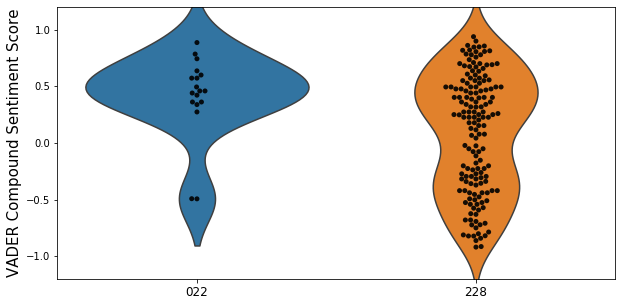

In [12]:
plt.close()
plt.figure(figsize=(10,5))
plt.ylim(-1.2,1.2)
sns.violinplot(x='let_id',y='cmpd_score',data=sentence_df[sentence_df['let_id'].isin(['022','228'])],inner=None)
sns.swarmplot(x='let_id', y='cmpd_score',data=sentence_df[sentence_df['let_id'].isin(['022','228'])], color='black', alpha=.9);
plt.xlabel('')
plt.xticks(size=12)
plt.ylabel('VADER Compound Sentiment Score',size=15);

When sorted according to the average sentiment, the letters with the most negative sentiment are the telegrams he wrote to his brother when his father had a stroke and died. The next most negative letter is #456, the letter he wrote to his brother after Miss Begemann poisoned herself.

In [13]:
df[['let_id','recipient','clean_text','avg_sentiment']].sort_values(by='avg_sentiment').head(4)

,let_id,recipient,clean_text,avg_sentiment
468,486,"Theo van Gogh, c/o Messrs Goupil, 19 boulevard...",sudden death come van gogh,-0.599400
470,488,"Theo van Gogh, c/o Messrs Goupil, rue Chaptal,...",our father fatal stroke van gogh,-0.542300
469,487,"Theo van Gogh, c/o 19 boulevard Montmartre, Paris",Our father fatal stroke come but it is over ...,-0.307100
438,456,Theo van Gogh,My dear Theo \nYou re quite right to ask why I...,-0.206609


If we look at the number of letters written each year, you can see that he wrote most in the years 1881-1884 and 1888. 1880 was when he moved further from his brother, which is likely why his writing increases. It could also be due to less surviving letters in the earlier years of correspondence.

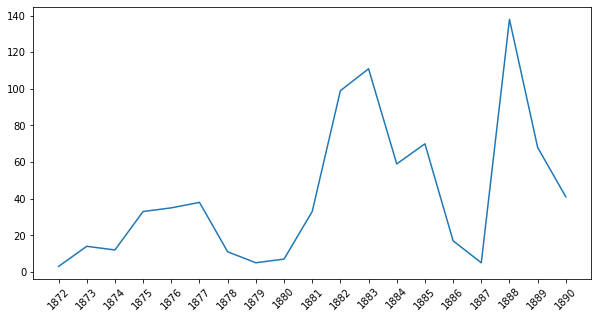

In [14]:
plt.figure(figsize=(10,5))
plt.plot(df.year.unique(),df.groupby('year').let_id.count())
plt.xticks(ticks=range(1872,1891), rotation=45);

Here we can see the negative sentiment of each letter, plotted over time. I will analyze this further in the analysis notebook.

In [18]:
df.drop(632).sort_values(by='let_id').perc_neg.rolling(20).mean().to_pickle('data/neg_sentiment_over_time.pkl')

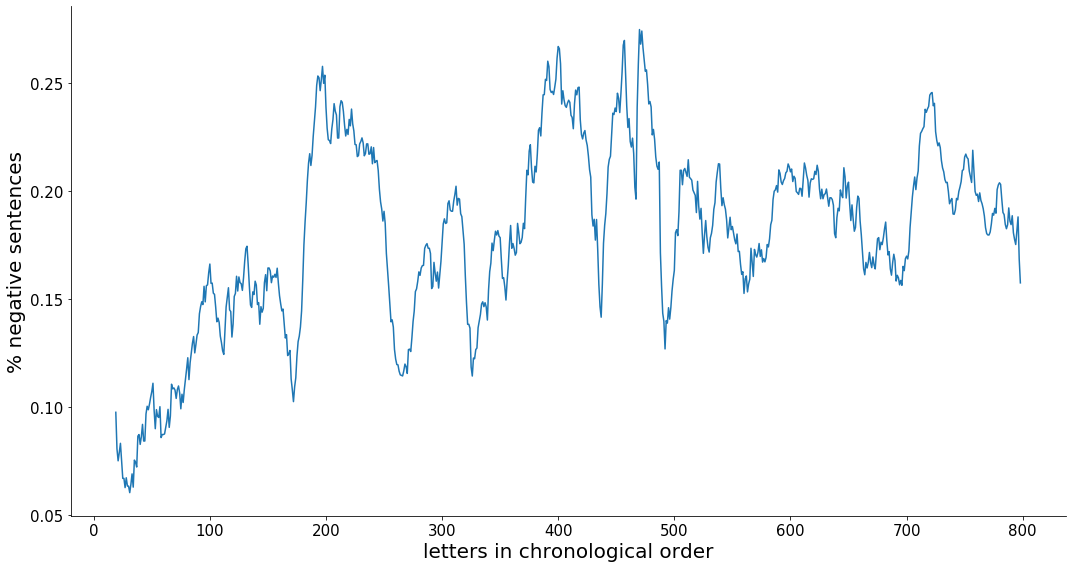

In [19]:
plt.figure(figsize=(15,8))
plt.plot(df.drop(632).sort_values(by='let_id').perc_neg.rolling(20).mean())
plt.ylabel('% negative sentences',fontsize=20)
plt.xlabel('letters in chronological order',rotation=0,fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
sns.despine();